**Problem 2 a): DermaMNIST**

In [1]:
# import necessary libraries

!pip install medmnist

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from medmnist import DermaMNIST
from medmnist import Evaluator
import torchvision.transforms as transforms



2025-03-21 22:53:31.416812: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 22:53:31.427708: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742597611.440321  186404 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742597611.443853  186404 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742597611.452895  186404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Loading the dataset
train_dataset = DermaMNIST(split="train", download=True)
val_dataset = DermaMNIST(split="val", download=True)
test_dataset = DermaMNIST(split="test", download=True)


Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz
Using downloaded and verified file: /teamspace/studios/this_studio/.medmnist/dermamnist.npz


In [3]:
# Original labels - Before one-hot encoding
print("Original label shape:", train_dataset.labels.shape)
print("First 5 labels:", train_dataset.labels[:5].flatten())

# labels shape - After one-hot encoding
labels_encoded = tf.keras.utils.to_categorical(train_dataset.labels, num_classes=7)
print("One-hot encoded label shape:", labels_encoded.shape)
print("First 5 one-hot encoded labels:\n", labels_encoded[:5])



Original label shape: (7007, 1)
First 5 labels: [0 5 5 5 4]
One-hot encoded label shape: (7007, 7)
First 5 one-hot encoded labels:
 [[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [4]:
# Normalization
def prepare_data(dataset):
    images = dataset.imgs / 255.0  
    labels = tf.keras.utils.to_categorical(dataset.labels, num_classes=7)
    return images, labels

x_train, y_train = prepare_data(train_dataset)
x_val, y_val = prepare_data(val_dataset)
x_test, y_test = prepare_data(test_dataset)


In [5]:
from sklearn.utils import class_weight

# Converting the one-hot encoded values to class labels
y_train_labels = np.argmax(y_train, axis=1)

# Computing class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: 4.390350877192983, 1: 2.788300835654596, 2: 1.3016905071521456, 3: 12.5125, 4: 1.2849807445442876, 5: 0.21329639889196675, 6: 10.11111111111111}


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-21 22:53:34.850562: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/150
110/110 - 5s - 49ms/step - accuracy: 0.3057 - loss: 2.1869 - val_accuracy: 0.0309 - val_loss: 2.8867
Epoch 2/150
110/110 - 4s - 33ms/step - accuracy: 0.3638 - loss: 1.7710 - val_accuracy: 0.1127 - val_loss: 2.5524
Epoch 3/150
110/110 - 4s - 32ms/step - accuracy: 0.4152 - loss: 1.6616 - val_accuracy: 0.0937 - val_loss: 2.5495
Epoch 4/150
110/110 - 4s - 32ms/step - accuracy: 0.4114 - loss: 1.6108 - val_accuracy: 0.1446 - val_loss: 2.2797
Epoch 5/150
110/110 - 4s - 32ms/step - accuracy: 0.4560 - loss: 1.4999 - val_accuracy: 0.5404 - val_loss: 1.2028
Epoch 6/150
110/110 - 4s - 33ms/step - accuracy: 0.4443 - loss: 1.4771 - val_accuracy: 0.4477 - val_loss: 1.4166
Epoch 7/150
110/110 - 4s - 33ms/step - accuracy: 0.4691 - loss: 1.4229 - val_accuracy: 0.3529 - val_loss: 1.4607
Epoch 8/150
110/110 - 4s - 32ms/step - accuracy: 0.4611 - loss: 1.4055 - val_accuracy: 0.3051 - val_loss: 1.5723
Epoch 9/150
110/110 - 4s - 32ms/step - accuracy: 0.4688 - loss: 1.3571 - val_accuracy: 0.4855 - 

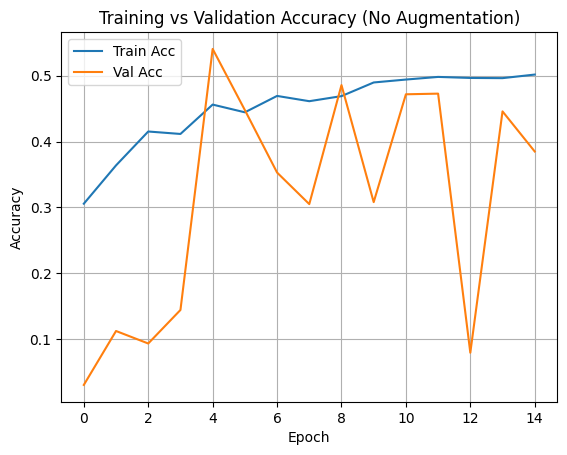

In [6]:
# Model 
def build_model():
    model = models.Sequential([
        # 1st Conv Layer
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3), padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 2nd Conv Layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),

        # 3rd Conv Layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        # layers.GlobalAveragePooling2D(), 
        layers.MaxPooling2D(),  
        layers.Dropout(0.3),

    # 4th Conv Layer 
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.4),
        
        layers.Flatten(),
        
    # Fully Connected Layers (3 Layers)
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(7, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model = build_model()

# 150 epochs
history = model.fit(
    x_train, y_train,
    epochs=150,
    batch_size=64,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    class_weight=class_weights, 
    verbose=2
)

# Learning Curves
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (No Augmentation)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

# Evaluation  metrics
print("\n--- Metrics WITHOUT Augmentation ---")
print(f"Test Loss: {test_loss:.5f}")
print(f"Test Accuracy: {test_acc:.5f}")
print(f"F1 Score: {f1_score(y_true, y_pred_classes, average='weighted'):.5f}")
print(f"Precision: {precision_score(y_true, y_pred_classes, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_true, y_pred_classes, average='weighted'):.5f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Metrics WITHOUT Augmentation ---
Test Loss: 1.18514
Test Accuracy: 0.53865
F1 Score: 0.58299
Precision: 0.65156
Recall: 0.53865


Epoch 1/150


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


110/110 - 6s - 56ms/step - accuracy: 0.6298 - loss: 1.1570 - val_accuracy: 0.1097 - val_loss: 1.7750
Epoch 2/150
110/110 - 5s - 45ms/step - accuracy: 0.6632 - loss: 0.9638 - val_accuracy: 0.1097 - val_loss: 1.8174
Epoch 3/150
110/110 - 4s - 38ms/step - accuracy: 0.6756 - loss: 0.9277 - val_accuracy: 0.2552 - val_loss: 1.6207
Epoch 4/150
110/110 - 5s - 46ms/step - accuracy: 0.6850 - loss: 0.8910 - val_accuracy: 0.6171 - val_loss: 1.1691
Epoch 5/150
110/110 - 4s - 38ms/step - accuracy: 0.6892 - loss: 0.8759 - val_accuracy: 0.6919 - val_loss: 0.9128
Epoch 6/150
110/110 - 5s - 46ms/step - accuracy: 0.6937 - loss: 0.8582 - val_accuracy: 0.6830 - val_loss: 0.8782
Epoch 7/150
110/110 - 4s - 37ms/step - accuracy: 0.7019 - loss: 0.8355 - val_accuracy: 0.6859 - val_loss: 0.8712
Epoch 8/150
110/110 - 5s - 47ms/step - accuracy: 0.6962 - loss: 0.8267 - val_accuracy: 0.7129 - val_loss: 0.7572
Epoch 9/150
110/110 - 4s - 38ms/step - accuracy: 0.7030 - loss: 0.8172 - val_accuracy: 0.7238 - val_loss: 0.

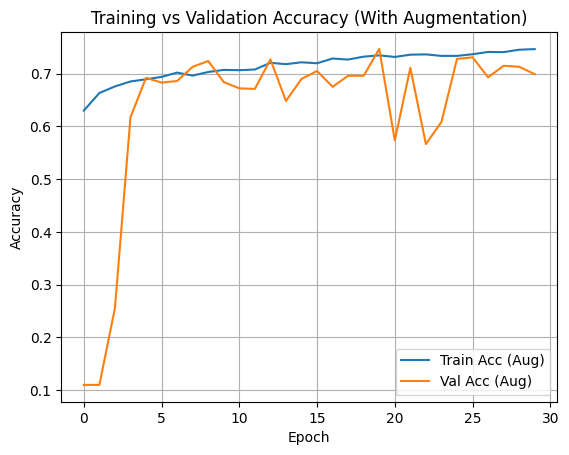

In [8]:
# using various image aug techniques
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,      
    zoom_range=0.2,        
    width_shift_range=0.1,   
    height_shift_range=0.1,  
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen.fit(x_train)

# retraining model with augmentation
aug_model = build_model()
aug_history = aug_model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=150,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=2
)

# Learning Curves (
plt.plot(aug_history.history['accuracy'], label='Train Acc (Aug)')
plt.plot(aug_history.history['val_accuracy'], label='Val Acc (Aug)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (With Augmentation)')
plt.legend()
plt.grid(True)
plt.show() 


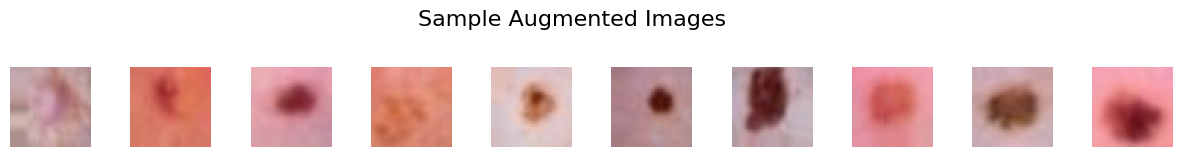

In [9]:
augmented_batch = datagen.flow(x_train, y_train, batch_size=64, shuffle=False)
sample_images, sample_labels = next(augmented_batch)

# Plotting 10 augmented images
num_images_to_show = 10
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 2))
axes = axes.ravel()

for i in range(num_images_to_show):
    axes[i].imshow(sample_images[i])
    axes[i].axis('off')

plt.suptitle("Sample Augmented Images", fontsize=16)
plt.subplots_adjust(wspace=0.5)
plt.show()


In [10]:
y_aug_pred = aug_model.predict(x_test)
y_aug_pred_classes = np.argmax(y_aug_pred, axis=1)

aug_test_loss, aug_test_acc = aug_model.evaluate(x_test, y_test, verbose=0)

# Evaluation metrics
print("\n--- Metrics WITH Augmentation ---")
print(f"Test Loss: {aug_test_loss:.5f}")
print(f"Test Accuracy: {aug_test_acc:.5f}")
print(f"F1 Score: {f1_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")
print(f"Precision: {precision_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")
print(f"Recall: {recall_score(y_true, y_aug_pred_classes, average='weighted'):.5f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Metrics WITH Augmentation ---
Test Loss: 0.70387
Test Accuracy: 0.74165
F1 Score: 0.71944
Precision: 0.71778
Recall: 0.74165


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
#model summary

aug_model = build_model()
aug_model.summary()


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 489,927 (1.87 MB)

 Trainable params: 488,967 (1.87 MB)

 Non-trainable params: 960 (3.75 KB)

1) The above CNN architecture consists of 4 convolutional layers, each followed by Batch Normalization, MaxPooling, and Dropout.
2) **Conv2D Layers:** The model begins with 4 convolutional layers which have 32, 64, 128 and 256 filters respectively. All these layers use 3x3 kernels and ReLU activation function to extract images.
3) **Batch Normalization, MaxPooling, and Dropout:** After each convolutional layer, batch normalization is applied.Next MaxPooling is then used to reduce the image dimensions. Here the model has Dropout of rates ranging from  (0.2 to 0.4) follows each block to prevent overfitting.
4) **Flatten Layer:** After the convolutional layers, the output feature maps are flattened into a 1D vector before passing into the dense layers.
5) **Fully Connected Layers:** There are 3 dense layers — the first with 256 neurons, the second with 128 neurons, and the final with 7 neurons (for the 7 classes), using softmax activation for multi-class classification.

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred_probs = model.predict(x_test)
y_aug_pred_probs = aug_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_aug_pred_classes = np.argmax(y_aug_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Dictionary for mapping class labels
skin_classes = {
    0: "Melanocytic Nevi",
    1: "Melanoma",
    2: "Benign Keratosis",
    3: "Basal Cell Carcinoma",
    4: "Actinic Keratosis",
    5: "Vascular Lesions",
    6: "Dermatofibroma"
}

# converting predicted numbers into class names
predicted_class_names = [skin_classes[label] for label in y_pred_classes]
actual_class_names = [skin_classes[label] for label in y_true]
correct_indices = np.where(y_pred_classes == y_true)[0]
print(f"Found {len(correct_indices)} correct predictions out of {len(y_true)} test samples.")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Found 1080 correct predictions out of 2005 test samples.


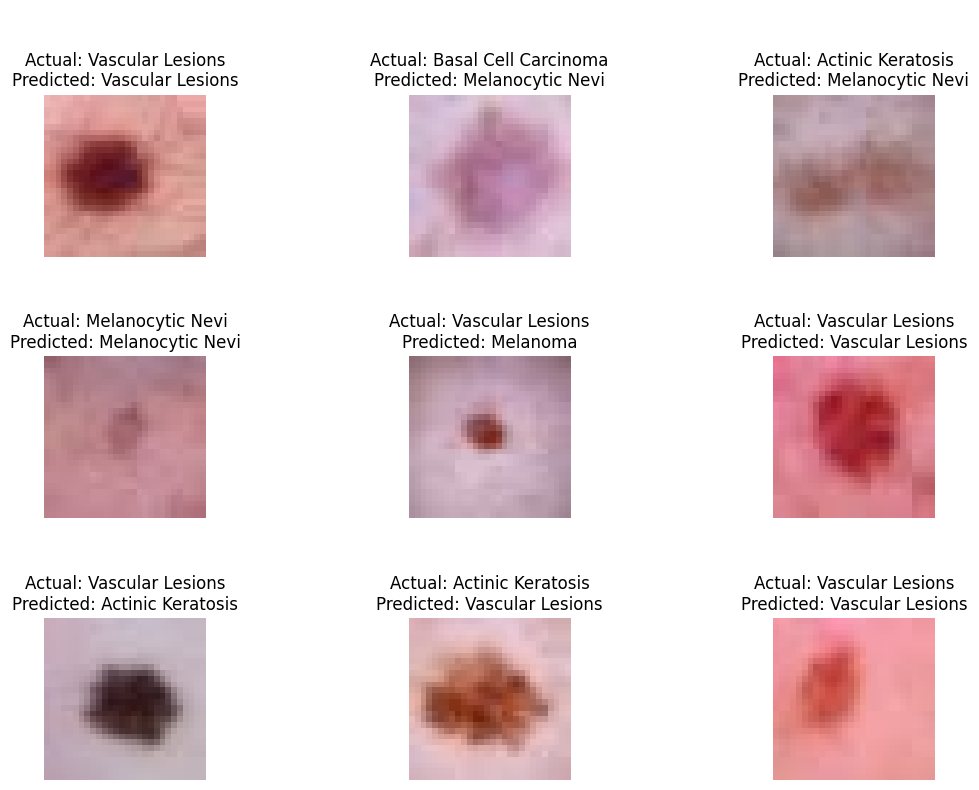

In [13]:
# show the actual vs. predicted labels
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(x_test[i])
    axes[i].axis('off')
    axes[i].set_title(f"\n\nActual: {actual_class_names[i]}\nPredicted: {predicted_class_names[i]}")

plt.tight_layout()
plt.show()


**Hyerparameters used**


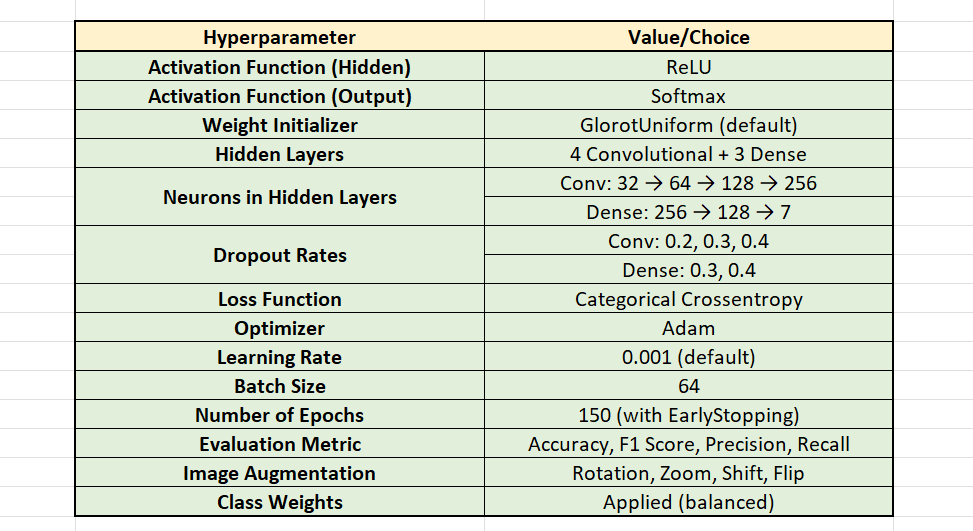

**Comparison table**
- By using data augmentation in the above model we can see that the model's **accuracy** increased significantly from **53.87%** to **74.17%** while **loss** decreased from **1.1851** to **0.7038**
- The **F1-score** also increased from **0.5829** to **0.7194** indicating better balance between precision and recall.
- **Precision** increased as well it went from **0.6516** to **0.7178**, while **recall** jumped from **0.5387** to **0.7417** showing improved prediction on minority classes.
- Therefoer we can say that augmentation helped reduce overfitting and improved generalization. 







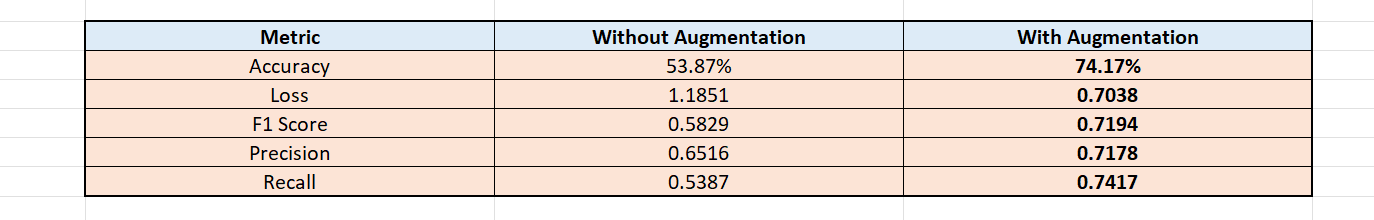

**Analysis:**
1) Overall got better Generalization: The model trained using augmentation resulted in overall better accuracy and F1-score, representing that it generalizes better to unseen test data.
2) Reduced Overfitting: Validation loss and accuracy curves are more stable with augmentation, suggesting less overfitting.
3) Improved Recall: Higher recall shows the model with augmentation is better at capturing more true positives across all classes.
4) Handling Class Imbalance: Augmentation along with class weights helped the model perform better on underrepresented classes.